In [1]:
#!/usr/bin/python3
import math
import json


states = [1,2,3,4,5]
utterances = [1,2,3,4,5]
quds = [ "state", "valence", "arousal"]
valences = ["positive", "negative"]
arousals = ["high", "low"]
affects = [(v, a) for v in valences for a in arousals]
contexts = ["WC1", "WC2","WC3","WC4","WC5","WC6","WC7","WC8","WC9"]

# For each context, prior over the states
prior_states = eval(open('irony/prior_states.json', 'r').read())
print("prior states: ", prior_states)
# For each state, prior over valence+arousal combination
prior_affect = eval(open('irony/prior_affect.json', 'r').read())

# Prior over QUDs
# hmmm was this ever calculated in the paper?
prior_quds = {
    "state":    0.3,
    "valence":  0.3,
    "arousal":  0.4,
}

rationality_factor = 1.0

# the q function in the paper
# 's' is the state of the world, 'A' reps the speaker's affect toward the state
# this serves as a projection from full meaning spact to subset of speaker's interest
def qud(q, s, A):
    if q == "state": return s
    if q == "valence": return A[0]
    if q == "arousal": return A[1]
    print("error")


def literal_listener(s, A, u):
    if s != u:          #if state does not == utterance. This is the basic RSA that returns priors for true states.
        return 0.0
    else:
        return prior_affect[s][A] #so the literal listener will return literally whatever the qud asks for. but what happens if the qud is the state? should we return the probability of a weather state happening? If it doesn't it probs won't change behavior because they're all uniform.


# the U function in the paper, without the log
# this models info gained by listener about topic of interest
# where q is the intended QUD

def exp_utility(u, s, A, q):
    sum = 0.0
    for sp in states:
        for Ap in affects:
            if qud(q, s, A) == qud(q, sp, Ap):
                sum += literal_listener(sp, Ap, u)
    return sum

# the S function in the paper, normalized
# "the speaker S chooses an utterance according to a softmax decision rule"
# in the paper, it says the base is e. How come it's the the utility ftn^ rationality factior here?
def speaker(u, s, A, q):
    norm = 0.0
    for up in utterances:
        norm += math.pow(exp_utility(up, s, A, q), rationality_factor)
    return math.pow(exp_utility(u, s, A, q), rationality_factor) / norm

# the pragmatic L function in the paper, unnormalized
# this is the ftn that models the ambiguity behind QUD, particularly it's held in the sum
def unnorm_pragmatic_listener(s, A, u, context):
    sum = 0.0
    for q in quds:
        sum += prior_quds[q] * speaker(u, s, A, q)
    return prior_states[context][s] * prior_affect[s][A] * sum


# the pragmatic L function in the paper, normalized
def pragmatic_listener(s, A, u, context):
    norm = 0.0
    for sp in states:
        for Ap in affects:
            norm += unnorm_pragmatic_listener(sp, Ap, u, context)
    return unnorm_pragmatic_listener(s, A, u, context) / norm

prior states:  {'WC3': {1: 0.018518518518518517, 2: 0.018518518518518517, 3: 0.018518518518518517, 4: 0.16666666666666666, 5: 0.7777777777777778}, 'WC4': {1: 0.018518518518518517, 2: 0.018518518518518517, 3: 0.2222222222222222, 4: 0.6296296296296297, 5: 0.1111111111111111}, 'WC8': {1: 0.5555555555555556, 2: 0.35185185185185186, 3: 0.05555555555555555, 4: 0.018518518518518517, 5: 0.018518518518518517}, 'WC5': {1: 0.018518518518518517, 2: 0.018518518518518517, 3: 0.18518518518518517, 4: 0.5925925925925926, 5: 0.18518518518518517}, 'WC7': {1: 0.09259259259259259, 2: 0.4074074074074074, 3: 0.3333333333333333, 4: 0.14814814814814814, 5: 0.018518518518518517}, 'WC6': {1: 0.018518518518518517, 2: 0.14814814814814814, 3: 0.5185185185185185, 4: 0.2777777777777778, 5: 0.037037037037037035}, 'WC9': {1: 0.5555555555555556, 2: 0.35185185185185186, 3: 0.05555555555555555, 4: 0.018518518518518517, 5: 0.018518518518518517}, 'WC1': {1: 0.018518518518518517, 2: 0.018518518518518517, 3: 0.018518518518518

In [2]:
from collections import defaultdict

output = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(float))))

def main():
    for context in contexts:
        #print("----------------------")
        #print("  CONTEXT: %s" % context)
        #print("----------------------")
        for u in utterances:
            #print("--- utterance: %s ----" % u)
            total_prob = 0.0
            for s in states:
                for A in affects:
                    prob = pragmatic_listener(s, A, u, context)
                    output[context][u][s][A] = prob
                    #print("  s: %s, A: %s:\t%f" % (s, A, prob))
                    total_prob += prob
            #print("  total_prob: %f" % total_prob)
main()

In [3]:
#example on marginalizing over the affect to get the probability of a state. This is done over every utterance/context combination
# for c in range(len(contexts)):
#     for u in output[contexts[c]].keys():
#         out = output[contexts[c]][u]
#         y = [sum(affect.values()) for affect in out.values()]
#         x = list(out.keys())

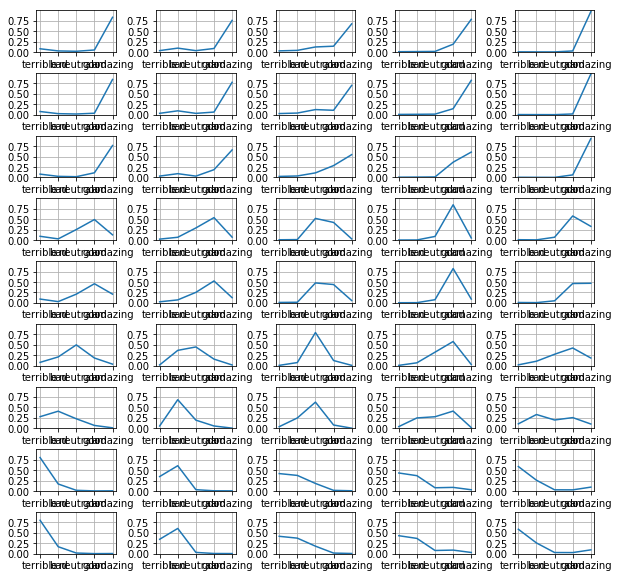

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 10))
labels = ["terrible", "bad", "neutral", "good", "amazing"]


for c in range(len(contexts)):
    for u in output[contexts[c]].keys():
        out = output[contexts[c]][u]
        y = [sum(affect.values()) for affect in out.values()]
        x = list(out.keys())

        ax1 = plt.subplot2grid((9,5),(c,u-1))
        ax1.set_ylim(0, 1)
        ax1.plot(list(out.keys()),y)
        plt.grid()
        plt.xticks(list(out.keys()), labels) 
        plt.yticks(np.arange(0.0, 1.0, 0.25))


fig.subplots_adjust(hspace=.5, wspace=.5)
plt.show()

In [6]:
#write output 
def ddict2dict(d):
    '''
    convert recursive defaultdict to dict
    '''
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = ddict2dict(v)
    return dict(d)

# for c in range(len(contexts)):
#     for u in output[contexts[c]].keys():
#         out = output[contexts[c]][u]
#         y = [sum(affect.values()) for affect in out.values()]
#         x = list(out.keys())

for c in range(len(contexts)):
    for u in output[contexts[c]].keys():
        out = output[contexts[c]][u]
        output[contexts[c]][u] = [sum(affect.values()) for affect in out.values()]
        
output = ddict2dict(output)
with open('fig_5_labels.json', 'w') as fp:
    fp.write(str(output))